# An Introduction to Ethical Supervised Learning

<hr/>

# Overview
In this tutorial, you will learn:
<ol>
<li> How to identify a discriminatory machine learning predictor</li>
<li> An introduction to fairness models in supervised learning</li>
<li> How to fix a basic discriminatory predictor with a fairness model through:
    <ul>
    <li> Understanding perfmorance metrics</li>
    <li> Minimizing loss</li>
    <li> Utilizing sensitivity / recall</li>
    </ul>
</li>
</ol>

<hr/>

# Part 1 : How to Identify a Discriminatory Predictor

## I. Introduction to TransRisk Scores

For this tutorial, we will be working with <b>TransRisk Scores</b> for four demographics. TransRisk scores aim to estimate how worthy a consumer is for credit. The scores range from 0 to 100, and are created using a variety of data points (such as history of paying back loans, how many credit card accounts you've had, employment rate, etc.) In theory, the closer a person's TransRisk score is to 100, the more likely they are to pay back a loan (similar to a FICO credit score). Banks and loan agencies typically use this kind of score combined with a <b>threshold value</b> to decide if someone should be granted a loan.<br/><br/>
For example, a bank that grants loans might set their threshold TransRisk score at 60. Then everyone with a TransRisk score of 60 or above recieves a loan, and everyone with a score below 60 automatically gets denied.<br/><br/>
The first data set you will work with shows the probability of an individual having a TransRisk score for different demographic groups. This can also be written as : 
<h3 align='center'> P(score = x | race)</h3>

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
ProbOfBeingScore = pd.read_csv("ProbOfBeingScore.csv").set_index("TransRisk Score")
ProbOfBeingScore.head()

,white,black,hispanic,asian
TransRisk Score,,,,
0.0,0.0000,0.0000,0.0000,0.0000
0.5,0.0025,0.0112,0.0046,0.0013
1.0,0.0090,0.0414,0.0175,0.0075
1.5,0.0027,0.0114,0.0052,0.0019
2.0,0.0037,0.0142,0.0075,0.0025


## II. Using Visualizations as a Guide

*** For a threshold score x, someone is given a loan if they have a TransRisk score >= x. Using this data set, create and plot a dataframe that shows the probability of an individual receiving a loan: ***
<h3 align='center'> P(score >= x | race)</h3>

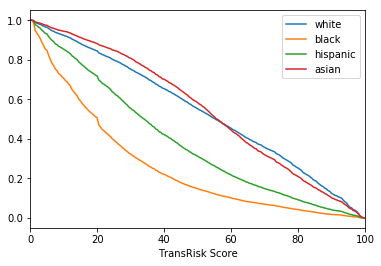

In [4]:
ProbOfGettingLoan = ProbOfBeingScore.iloc[::-1].cumsum()[::-1]
ProbOfGettingLoan.plot.line()

## III. Interpretation

Using our previous example of a threshold score x = 60, take a look at your visualization. With a score of 60, what is the probability for an individual of each race to receive a loan?

In [5]:
# Show Probabilities Here
ProbOfGettingLoan.loc[60]

white       0.4535
black       0.1015
hispanic    0.2176
asian       0.4455
Name: 60.0, dtype: float64

It is pretty clear that discrimination is occuring here. If a bank chooses a threshold score of 60, the white demographic would be more than 4x as likely to get a loan than the black demographic. This could happen for a variety of reasons, including (but not limited to):
- The data that was used to create a TransRisk score (such as amount of bank accounts opened) might unintentionally discriminate against certain demographic groups.
- Machine learning predictors are inherently less accurate for minority populations, since smaller population sizes lead to lower predictor performance.

<hr/>

# Part 2 : Introduction to Fairness Models

## I. What is a fairness model?

Fairness models seek to solve the problem that you identified in Part 1. Specifically, they allow data scientists to algorithmically and statistically measure how <i>fair</i> a predictor is by providing requirements to ensure <i>fairness</i>.

## II. Equal Opportunity Model

This model will work well for the TransRisk dataset, because it provides simple requirements for a binary predictor. This model takes into account three factors:
<ol>
<li>Groups that are defined by a protected attribute (this will be the four demographic groups in our example) | Denoted as 'A'</li>
<li>The advantaged outcome group (we will discuss this in Part 3) | Denoted as 'Y = 1'</li>
<li>The binary predictor (getting granted a loan) | Denoted as '$\hat Y$ = 1' for a loan approval and '$\hat Y$ = 0' for loan denial</li>
</ol>

A Predictor is said to satisfy fairness under Equal Opportunity iff the probability of getting a positive prediction is the same for all advantaged outcome members in a protected group. <br/><br/>
<div align='center'>
*** P($\hat Y$ = 1 | A = a, Y = 1) is equal for ALL protected groups a. ***</div>


<hr/>

# Part 3 : Fixing a Discriminatory Predictor Through the Equal Opportunity Model

## I. Understanding Performance Metrics

Here we will introduce two more data sets on these TransRisk scores. 
<ol>
<li><b>ProbGoodGivenRace </b>: P(good | race)
    <ul>
    <li> Represents the probability that an individual of a race is 'good' (non-defaulting)</li>
    <li> <i>Note that the 'good' non-defaulters represent the advantaged outcome group defined in Part 2, for all 'good' individuals of a race,'Y = 1'</i></li>
    </ul>
</li><br/>
<li><b>ProbLoanReceiverIsGood </b> : P(good | score >= x, race)
    <ul>
    <li> Represents the probability that an individual who has been granted a loan is actually 'good'</li>
    <li><i>Remember that with a threshold score x, everyone with a score >= x is granted a loan.</i></li>
    </ul>
</li>
</ol>

Read them in and make sure you understand what the data represents before moving onto the next section.

In [6]:
ProbGoodGivenRace = pd.read_csv("ProbGoodGivenRace.csv")
ProbLoanReceiverIsGood = (
    pd.read_csv("ProbLoanReceiverIsGood.csv")
    .set_index("TransRisk Score"))

<hr/>

<div align='center'>

<h3> The General Multiplication Rule:</h3><br/>
<b>Definition : </b> For any two events, we can say that
<h4 > P(A and B) = P(A) * P(B | A)</h4><br/>
<i>"The probability that both A and B occur = the probability that A occurs multiplied by the probability that B occurs, given that A has occured."</i></div>

<hr/>

To work with the conditions introduced by the Equal Opporunity Model, we need to find<br/>
<div align='center'>P($\hat Y$ = 1 | A = a, Y = 1)</div><br/>
For our case study, this would be the Probability that someone has received a loan, given their race and the fact that they are good. Also stated:<br/>
<div align='center'>P(score >= x | race, good)</div><br/>
Using your knowledge of the multiplication rule with all three data sets you have been given on TransRisk scores, create a DataFrame that shows this probability for each TransRisk score and demographic.

In [7]:
white_s = (ProbOfGettingLoan[["white"]] * ProbLoanReceiverIsGood[["white"]]) / ProbGoodGivenRace["white"][0]
black_s = (ProbOfGettingLoan[["black"]] * ProbLoanReceiverIsGood[["black"]]) / ProbGoodGivenRace["black"][0]
asian_s = (ProbOfGettingLoan[["asian"]] * ProbLoanReceiverIsGood[["asian"]]) / ProbGoodGivenRace["asian"][0]
hispanic_s = (ProbOfGettingLoan[["hispanic"]] * ProbLoanReceiverIsGood[["hispanic"]]) / ProbGoodGivenRace["hispanic"][0]

In [8]:
s = [white_s, black_s, asian_s, hispanic_s]
sensitivities = pd.concat(s, axis= 1)
sensitivities.head()

,white,black,asian,hispanic
TransRisk Score,,,,
0.0,1.000000,0.999998,1.000000,1.000000
0.5,1.000000,0.999998,1.000000,1.000000
1.0,1.000000,0.999838,1.000000,0.999827
1.5,0.999696,0.996967,0.999431,0.999472
2.0,0.999599,0.996298,0.999431,0.999472


## II. Minimizing Loss

For supervised learning predictors, one way to detect errors is to calculate the difference between the actual output and the predictor's output. The function used to compute the error of a predictor is called a <b>Loss Function</b>. For our dataset, we calculate loss in a similar manner to how banks giving loans would. Specifically we want to make the <i><b>Precision = 0.82</b></i>.
<h3 align='center'> Precision = P(Y = 1 | $\hat Y$ = 1) == P(good | score >= x)</h3><br/>
Here we provide another dataset that shows the percentage of each demographic in the total sample size, or rather P(race). Using this information and the multiplication rule, find the precision at every TransRisk threshold x. Then, plot the sensitivity (y axis) against the precision (x axis) to see what is happening to the sensitivities at precision=0.82.

In [9]:
# This represents P(race)
ProbOfBeingRace = pd.read_csv("ProbOfBeingRace.csv").set_index("Demographic")
ProbOfBeingRace

,Sample Size,Percentage
Demographic,,
white,133165,0.765109
black,18274,0.104995
hispanic,14702,0.084471
asian,7906,0.045425


In [10]:
# Calculate precision
asianPrecision = ProbLoanReceiverIsGood["asian"] * ProbOfBeingRace.loc['asian']["Percentage"]
whitePrecision = ProbLoanReceiverIsGood["white"] * ProbOfBeingRace.loc['white']["Percentage"]
blackPrecision = ProbLoanReceiverIsGood["black"] * ProbOfBeingRace.loc['black']["Percentage"]
hispanicPrecision = ProbLoanReceiverIsGood["hispanic"] * ProbOfBeingRace.loc['hispanic']["Percentage"]
totalPrecision = (asianPrecision + whitePrecision + blackPrecision + hispanicPrecision).fillna(value=1)

In [11]:
totalPrecision

TransRisk Score
0.0      0.696915
0.5      0.696915
1.0      0.698996
1.5      0.706558
2.0      0.708835
2.5      0.711879
3.0      0.714343
3.5      0.718252
4.0      0.721671
4.5      0.725398
5.0      0.726698
5.5      0.732279
6.0      0.736837
6.5      0.741503
7.0      0.744155
7.5      0.748785
8.0      0.750891
8.5      0.754801
9.0      0.756611
9.5      0.759379
10.0     0.761630
10.5     0.764472
11.0     0.766503
11.5     0.770013
12.0     0.772925
12.5     0.778489
13.0     0.781426
13.5     0.785305
14.0     0.788526
14.5     0.794242
           ...   
85.0     0.982913
85.5     0.982752
86.0     0.982558
86.5     0.982458
87.0     0.982335
87.5     0.982525
88.0     0.982848
88.5     0.982884
89.0     0.983893
89.5     0.984095
90.0     0.984718
90.5     0.984949
91.0     0.985695
91.5     0.985906
92.0     0.985889
93.0     0.986274
93.5     0.985909
94.0     0.985741
94.5     0.986353
95.0     0.988331
95.5     0.988020
96.0     0.988191
96.5     0.988066
97.0     0.9

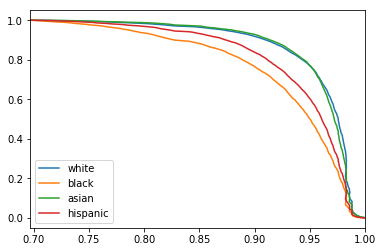

In [93]:
# plot precision against sensitivity
sensitivities.plot.line(x=totalPrecision)

*** What four sensitivity values are associated with a precision of 0.82? *** (put answer below)

In [16]:
sensitivities["Total Precision"] = totalPrecision
closestPrecision = min(sensitivities["Total Precision"], key=lambda x:abs(x-0.82))
sensitivities[sensitivities["Total Precision"] == closestPrecision]

,white,black,asian,hispanic,Total Precision
TransRisk Score,,,,,
18.5,0.975304,0.908524,0.980886,0.952457,0.820645


## III. Utilizing Sensitivity

We finally have all of the peices to fix the discriminatory predictor using the Equal Opportunity Model. As you just learned in Section II, our desired loss directly leads to a precision of 0.82. Looking back at the requirements for Equal Opportunity, we can see it requires that P($\hat Y$ = 1 | A = a, Y = 1) is equal for ALL protected groups a. This can also be stated that the <b>true positive rate</b> is equal for ALL protected groups a. Or even further, that the <b><i>Sensitivity</i></b> is equal for ALL protected groups a.<br/><br/>
As we saw in the last section, at a precision of 0.82, there are four different sensitivity values. But to satisfy equal opportunity, we must choose one sensitivity for all demographics. We will choose the average value of the four sensitivity values you found in section II. <br/><br/>
Using this average sensitivity value, now you simply need to find the scores associated with that value for each demographic. These scores represent the threshold that needs to be set for that particular demographic in order to satisfy 'fairness'. Start by plotting out the sensitivity (y axis) vs TransRisk scores (x axis) to visualize what you are doing. From there, record the final four threshold values needed to satisfy the Equal Opportunity Model.

In [18]:
sensGoal = (sensitivities[sensitivities["Total Precision"] == closestPrecision]
            [['white', 'black', 'asian', 'hispanic']].values.mean())

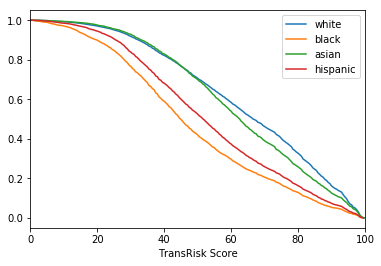

In [19]:
### Plot your sensitivites here:

sensitivities[['white', 'black', 'asian', 'hispanic']].plot.line()

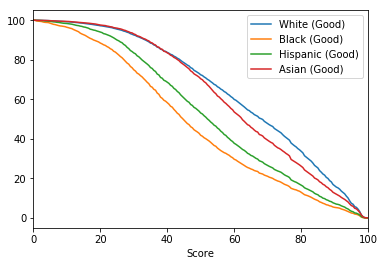

In [10]:
## For reference for the meeting on Wed, here is the actual solution with correct sensitivity, I think these are 
## almost equal
FinalSolution = pd.read_csv("FinalSolution.csv").set_index("Score")
FinalSolution.plot.line()

In [11]:
## Calculate your final answers here:

In [20]:
closestSensitivity = min(sensitivities["white"], key=lambda x:abs(x-sensGoal))
sensitivities[sensitivities["white"] == closestSensitivity][['white']]

,white
TransRisk Score,
24.5,0.953754


In [21]:
closestSensitivity = min(sensitivities["black"], key=lambda x:abs(x-sensGoal))
sensitivities[sensitivities["black"] == closestSensitivity][['black']]

,black
TransRisk Score,
13.0,0.95477


In [22]:
closestSensitivity = min(sensitivities["hispanic"], key=lambda x:abs(x-sensGoal))
sensitivities[sensitivities["hispanic"] == closestSensitivity][['hispanic']]

,hispanic
TransRisk Score,
18.0,0.955125


In [23]:
closestSensitivity = min(sensitivities["asian"], key=lambda x:abs(x-sensGoal))
sensitivities[sensitivities["asian"] == closestSensitivity][['asian']]

,asian
TransRisk Score,
25.5,0.954692


<hr/>

# Results & Conclusions

<i><h4>Congratulations!</h4></i><br/> You have successfully taken a discriminatory predictor and utilized a machine learning fairness model to make it into a 'fair' predictor. 
<ul>
<li> Through visualizing the probability of a beneficial outcome, it was quite clear that the data involved in creating the supervised learning predictors for loan approval from TransRisk scores was inherently discriminatory.</li>
<li> The Equal Opportunity Model provided a clear requirement to ensure fairness. As we learned later, this meant that the sensitivity (the true positive rate) of the predictor had to be the same for all races.</li>
<li> Using loss minimization, you were able to use precision to find the single sensitivity that provided the least amount of loss.</li>
<li> Finally, you discovered four new threshold values to be used; one for each demographic.</li>
</ul>
<br/><br/>

<div align='center'><i>What other commonly found predictors do you think might be inherently discriminatory?</i></div>
<br/><br/>

TransRisk data and non-discriminatory analysis courtesy of https://arxiv.org/pdf/1610.02413.pdf